In [58]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose, Resize, AutoAugment, RandomInvert, RandomGrayscale, RandomHorizontalFlip, RandomVerticalFlip, ConvertImageDtype
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")


# Imagenet Challenge 
## And the other datasets: MNIST, Fashion MNIST, CIFAR-10

I wamnt to code up Resnet, justifying it's structural need, using these datasets.  I want to see for myself:

- [ ] Linear models alone aren't good enough
- [ ] Convolution actually matters 
- [ ] Batch Norm matters
- [ ] Pooling matters
- [ ] Skip connections matter
- [ ] Large numbers of layers matter  

Etc...  Because I have found that most claims in the literature are correct, but some seem more solid than others.  Also, even the best claims typically break down at some point.  Only by testing with a skaptical eye can I truely understand. 

### Notes on Models:

**SingleLinear10**:  This model only flattens the data then linearly maps to the targets classes:
* 

### Load the datasets

* MNIST
* Fashion MNIST
* CIFAR-10
* Imagenet

In [59]:
# Dataset Classes

def make_transforms(size=None):
    tt = [ToTensor()]
    vt = [ToTensor()]

    if size is not None:
        tt.append(Resize((size,size)))
        vt.append(Resize((size,size)))

    train_transforms = Compose(tt)
    valid_transforms = Compose(vt)

    return train_transforms, valid_transforms


class MNIST:
    def __init__(self, batch_size=64, size=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size)
        self.train = datasets.MNIST(root='data', train=True, transform=train_transforms)
        self.val = datasets.MNIST(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)

class FashionMNIST:
    def __init__(self, batch_size=64, size=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size)
        self.train = datasets.FashionMNIST(root='data', train=True, transform=train_transforms)
        self.val = datasets.FashionMNIST(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)


class CIFAR10:
    def __init__(self, batch_size=64, size=None) -> None:
        # Get datasets
        train_transforms, valid_transforms = make_transforms(size)
        self.train = datasets.CIFAR10(root='data', train=True, transform=train_transforms)
        self.val = datasets.CIFAR10(root='data', train=False, transform=valid_transforms)

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = batch_size, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = batch_size, shuffle=True)



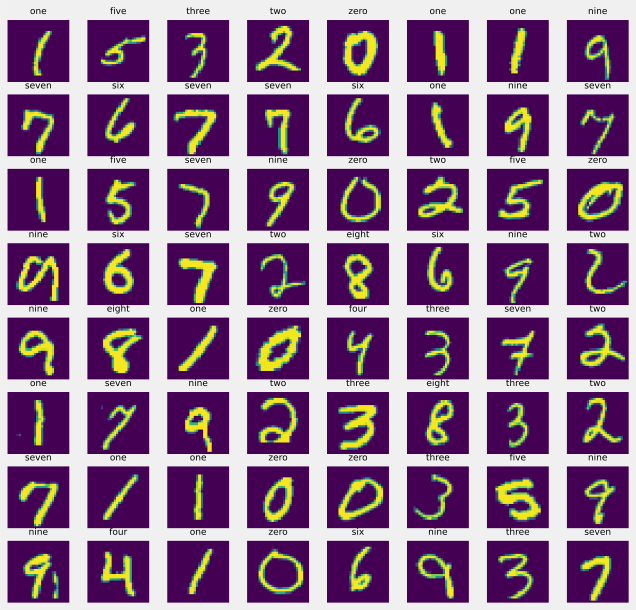

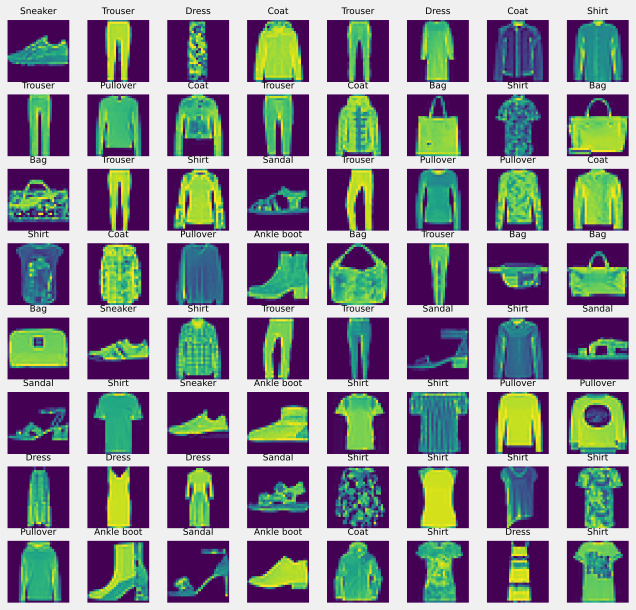

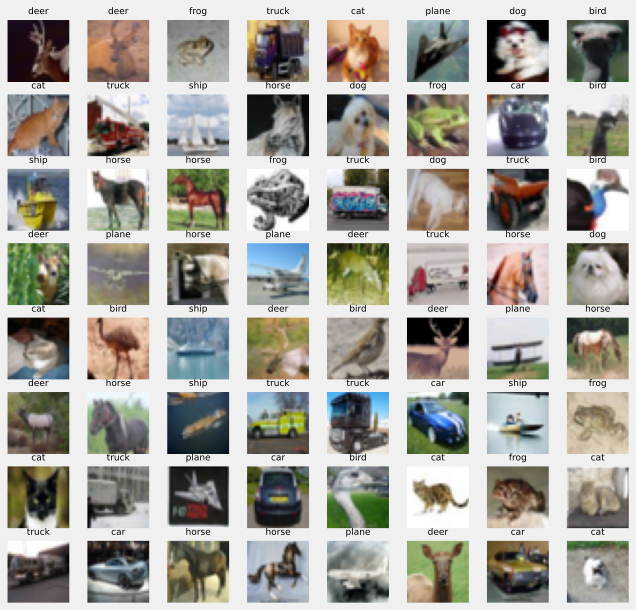

In [60]:
# Check out dataset
def plot_data_check(data, labels, title):
    plt.figure(figsize=(10, 10))
    x, y = next(iter(data.train_dl))

    for i in range(64):

        plt.subplot(8, 8, i+1)
        img = x.permute(0, 2, 3, 1)
        plt.imshow(img[i])
        plt.title(labels[y[i].item()], fontsize=9)
        plt.axis('off')


# Test loading the data
# MNIST
data = MNIST()
labels = ['zero', 'one', 'two', 'three', 'four',
          'five', 'six', 'seven', 'eight', 'nine']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")

# Fashion MNIST
data = FashionMNIST()
labels = ['Shirt','Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")


# CIFAR-10
data = CIFAR10()
labels = ['plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)
plot_data_check(data, labels, "MNIST")



### Models

#### Building up through ResNETs

In [61]:
# Base Model and building blocks
class MyModule(nn.Module):
    def __init__(self, lr=0.0001):
        super().__init__()
        self.learning_rate = lr

    def forward(self, x):
        out = self.model(x)
        return out

    def init_cnn(self, module):  # @save
        """Initialize weights for CNNs."""
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            # nn.init.xavier_uniform_(module.weight)
            nn.init.kaiming_normal_(
                module.weight, mode='fan_in', nonlinearity='relu')

    def init(self, x):
        logits = self.model(x)
        self.model.apply(self.init_cnn)
        return logits

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()

    def loss_fn(self, logits, y):
        loss = nn.functional.cross_entropy(logits, y)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate)






In [62]:
# Single Linear Model
class SingleLinear10(MyModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Flatten(), nn.LazyLinear(10))

In [63]:
# Test Models
device = "mps"

# Data
#data = MNIST()
#data = FashionMNIST()
data = CIFAR10()

# Model
model = SingleLinear10().to(device)

# Get instance
x, y = next(iter(data.train_dl))
x, y = x.to(device), y.to(device)

print ('\n* x array shape:')
print (x.shape)

print ('\n* Logits array shape:')
logits = model.init(x)
print (logits.shape)

# Number of parameters
print(f'\n* Model "{model.__class__.__name__}" has \
{sum([p.numel() for p in model.parameters()])} parameters')

print ('\n* Model:')
print (model)



* x array shape:
torch.Size([64, 3, 32, 32])

* Logits array shape:
torch.Size([64, 10])

* Model "SingleLinear10" has 30730 parameters

* Model:
SingleLinear10(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=10, bias=True)
  )
)


In [72]:
device = "mps"
max_epochs = 100
train_lr = False
LR = 1e-3
batch_size=512

try:
    del(model)
    del(x)
    del(y)
    del(vx)
    del(vy)
except:
    pass

# Data
data = MNIST(batch_size=batch_size)
#data = FashionMNIST(batch_size=512)
#data = CIFAR10(batch_size=1024)


# Model
#model = SingleLinear().to(device)
#model = DoubleLinear().to(device)""
#model = TripleLinear100().to(device)
#model = TripleLinear100().to(device)
model = SingleLinear10().to(device)


# Initialize model and get first statistics using validation data
x, y = next(iter(data.val_dl))
x, y = x.to(device), y.to(device)
val_logits = model.init(x)

# Number of parameters
print(f'Model "{model.__class__.__name__}" has {sum([p.numel() for p in model.parameters()])} parameters')


# Initial loss
val_loss = model.loss_fn(val_logits, y).item()
val_acc = model.accuracy(val_logits, y).item()
print(f'Epoch {0:>3d} has train loss {val_loss:.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')


N = len(data.train_dl)
lr = torch.logspace(-6, -3, N)
losses = torch.zeros(N)
min_loss = 9999999.
min_epoch = 0
if train_lr is False:
    model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = ReduceLROnPlateau(model.optimizer, 'min', factor=0.5, verbose=True)
epochs = [0]
ptloss = [val_loss]
pvloss = [val_loss]
pvacc = [val_acc]
for epoch in range(1, max_epochs+1):
    model.train()
    if epoch % 400 == 0:
        LR = LR/2.0
        print (f'Changing LR to {LR}')
        model.optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    for step, batch in enumerate(data.train_dl):

        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        losses[step] = train_loss.item()

        # Update
        if train_lr:
            model.optimizer = torch.optim.AdamW(model.parameters(), lr=lr[step])
        model.optimizer.zero_grad(set_to_none=True)
        train_loss.backward()
        model.optimizer.step()

        #if step % 20 == 0:
        #    print(f'step {step} has loss {train_loss.item()}')
    
    if train_lr:
        break
    # Evaluate for epoch
    model.eval()
    with torch.no_grad():
        vx, vy = next(iter(data.val_dl))
        vx, vy = vx.to(device), vy.to(device)
        val_logits = model(vx)
        val_loss = model.loss_fn(val_logits, vy).item()
        val_acc = model.accuracy(val_logits, vy).item()
        epochs.append(epoch)
        ptloss.append(train_loss.item())
        pvloss.append(val_loss)
        pvacc.append(val_acc)
        scheduler.step(val_loss)

        # Early Stopping
        if val_loss < min_loss:
            min_loss = val_loss
            min_epoch = epoch
        else:
            if epoch - 20 > min_epoch:
                break

    if epoch % 5 == 0:
        print(f'Epoch {epoch:>3d} has train loss {train_loss.item():.4f}, val loss {val_loss:.4f}, and accuracy {val_acc:.4f}')

    #break


if train_lr is False:
    # Get final training loss:
    model.eval()
    ftloss = []
    for batch in data.train_dl:
        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        train_logits = model(x)

        # Get loss
        train_loss = model.loss_fn(train_logits, y)
        ftloss.append(train_loss)

    fvloss = []
    fvacc = []
    for batch in data.val_dl:
        # Get Minibatch
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get logits
        val_logits = model(x)

        # Get loss
        val_loss = model.loss_fn(val_logits, y)
        val_acc = model.accuracy(val_logits, y).item()
        fvloss.append(val_loss)
        fvacc.append(val_acc)


    ftloss = torch.tensor(ftloss).mean().item()
    fvloss = torch.tensor(fvloss).mean().item()
    fvacc = torch.tensor(fvacc).mean().item()


    # Plot
    plt.figure()
    #epochs = torch.arange(max_epochs + 1).detach()
    plt.plot(epochs, ptloss, 'C0-', label=f'Training {ftloss:.2f}')
    plt.plot(epochs, pvloss, 'C1--', label=f'Validation {fvloss:.2f}')
    plt.plot(epochs, pvacc, 'C2:', label=f'Accuracy {fvacc:.2f}')
    plt.ylim(0,2)
    plt.xlabel('Epochs')
    plt.legend();
else:
    plt.semilogx(lr, losses)



Model "SingleLinear10" has 7850 parameters
Epoch   0 has train loss 2.2991, val loss 2.2991, and accuracy 0.1055
Epoch   5 has train loss 0.4022, val loss 0.3729, and accuracy 0.8926
Epoch  10 has train loss 0.3265, val loss 0.3473, and accuracy 0.9043


KeyboardInterrupt: 